# Head

In [1]:
import pandas as pd
from pathlib import Path
home = Path.home()

# models = ['qwen3', 'gemma3', 'llama4', 'qwq']
models = ['llama4', 'gemma3']

# suffixes = None
# suffixes = '_sent_shuffle'
suffixes = '_tail'

if suffixes is not None:
    csv_files = [home / f'projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/{model}{suffixes}.txt' for model in models]
else:
    csv_files = [home / f'projects/TLDR/data/paper_html_10.1038/abs_annotation/generated_annotations/{model}.txt' for model in models]

df = pd.read_csv(home / 'projects/TLDR/data/paper_html_10.1038/abs_annotation/test.tsv', sep='\t')
for model, csv_file in zip(models, csv_files):
    single_df = pd.read_csv(csv_file, sep='\t', header=None, names=[model])
    df = df.join(single_df)

for index in pd.read_csv(home / "projects/TLDR/description/invalid_entry_in_test.txt", sep='\t', header=None).values.flatten().tolist():
    df = df.drop(index-2)  # Adjusting for zero-based index
df

,doi,paper_id,abstract,annotation,llama4,gemma3
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...,This study reports on mtDNA variation in domes...,Reference 48 reports evidence for two independ...
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...,The data also highlight the value of this reso...,Reference 37 demonstrates a hybrid origin of m...
2,10.1073/pnas.96.16.9252,122095374,We previously mapped a quantitative trait locu...,This paper shows how the identity-by-descent a...,This study combines two different methods used...,This reference reports fine-mapping of a QTL f...
3,10.1101/gr.10.2.220,100831446,A genome-wide linkage disequilibrium (LD) map ...,The pattern of linkage disequilibrium (LD) acr...,This study examines the role of genetic drift ...,Reference 49 describes the use of LD mapping i...
4,10.1126/science.8134840,17452622,The European wild boar was crossed with the do...,The first paper to show the use of divergent i...,This study provides a comprehensive analysis o...,This study reports the identification of a maj...
...,...,...,...,...,...,...
35631,10.2337/db08-1168,4860455,OBJECTIVE—Regulatory T-cells (Tregs) have cata...,This article describes the good manufacturing ...,These results have implications for future stu...,Reference 52 reports on the expansion of human...
35632,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...,This study demonstrates that low dose IL-2 sel...,This short communication reports that low-dose...
35633,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...,This study identifies a previously unrecognize...,This work reports that hybrid peptides generat...
35634,10.1073/pnas.1902566116,82979762,Polymorphic HLAs form the primary immune barri...,This article describes the development of gene...,This study describes engineering of human cell...,This reference details a gene therapy approach...


# Overlap-based

In [2]:
import evaluate

def evaluate_metrics(df, pred_col='prediction', ref_col='reference'):
    references = df[ref_col].tolist()
    predictions = df[pred_col].tolist()

    # BLEU
    bleu = evaluate.load("bleu")
    bleu_result = bleu.compute(
        predictions=predictions,                 # 每个元素是一个字符串
        references=[[ref] for ref in references] # 每个元素是字符串列表
    )

    # METEOR
    meteor = evaluate.load("meteor")
    meteor_result = meteor.compute(predictions=predictions, references=references)

    # ROUGE
    rouge = evaluate.load("rouge")
    rouge_result = rouge.compute(
        predictions=predictions,
        references=references,
        rouge_types=["rouge1", "rouge2", "rougeL"]
    )

    # 只返回需要的分数，便于后续统计平均
    rouge_f = {rouge_type: rouge_result[rouge_type] if rouge_result is not None else None 
               for rouge_type in ["rouge1", "rouge2", "rougeL"]}

    return {
        'bleu': bleu_result["bleu"] if bleu_result is not None else None,
        'rouge': rouge_f,
        'meteor': meteor_result["meteor"] if meteor_result is not None else None,
    }

/opt/anaconda3/envs/zqlyuTLDR/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Human-written annotations as references

### LLMs' performance

In [3]:
evaluate_metrics(df, pred_col='gemma3', ref_col='annotation')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.019887477342082245,
 'rouge': {'rouge1': np.float64(0.24788200505452687),
  'rouge2': np.float64(0.05090276476031293),
  'rougeL': np.float64(0.19192940494990046)},
 'meteor': np.float64(0.20307779408308785)}

In [4]:
evaluate_metrics(df, pred_col='llama4', ref_col='annotation')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.018902567305634575,
 'rouge': {'rouge1': np.float64(0.23938686971344814),
  'rouge2': np.float64(0.0459321530817411),
  'rougeL': np.float64(0.1819147074966649)},
 'meteor': np.float64(0.1985158543224368)}

In [5]:
evaluate_metrics(df, pred_col='qwen3', ref_col='annotation')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lyuzhuoqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.011977842430480163,
 'meteor': 0.2444276480952033,
 'rouge': {'rouge1': 0.2209834534176697,
  'rouge2': 0.04533792571342782,
  'rougeL': 0.1550987958773836}}

### Multi-annotated abstracts as a human-evaluation baseline

In [ ]:
full = pd.read_csv(home / 'projects/TLDR/data/paper_html_10.1038/abs_annotation/abs_annotation.tsv', sep='\t')
print('# of papers: ', full['paper_id'].nunique())

multi_annotated = full[full['paper_id'].isin(full['paper_id'].value_counts()[full['paper_id'].value_counts() > 1].index)]
display(multi_annotated)
print(multi_annotated['paper_id'].unique().shape[0], 'papers are annotated by multiple annotators')

# of papers:  29356


,abs_doi,paper_id,abstract,annotation
0,10.1073/pnas.91.7.2757,107202074,The origin and taxonomic status of domesticate...,A demonstration that cattle have been domestic...
1,10.1093/genetics/154.4.1785,83366887,Abstract The domestic pig originates from the ...,Evidence is presented for independent domestic...
7,10.1083/jcb.153.2.397,58551536,The correct positioning of the nucleus is ofte...,Using live imaging and computer simulation the...
8,10.1101/gad.14.6.690,131922988,E2F is a family of transcription factors that ...,"Disruption of mouse E2f3 , but not E2f1 , redu..."
10,10.1101/gad.859201,18000382,Telomere shortening is the mechanism underlyin...,Growing primary human keratinocytes and mammar...
...,...,...,...,...
35633,10.1126/scitranslmed.aad4134,103721459,Autologous regulatory T cells can be expanded ...,First clinical trial demonstrating up to 1 yea...
35634,10.1084/jem.20040139,83080620,The low number of CD4+ CD25+ regulatory T cell...,Seminal study showing that antigen-specific T ...
35637,10.1126/science.aar3246,4860145,Engineering cytokine-receptor pairs Interleuki...,This study reports the generation of an orthog...
35638,10.1126/science.aad2791,62290395,T cells target peptide combos One of the endur...,This article shows that some diabetogenic T ce...


4019 papers are annotated by multiple annotators


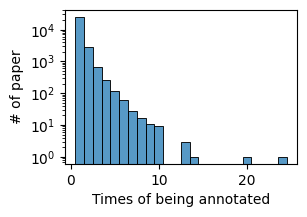

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

paper_id_counts = full['paper_id'].value_counts()
plt.figure(figsize=(3, 2))
sns.histplot(x=paper_id_counts, bins=30, stat='count', discrete=True)
plt.yscale('log')
plt.xlabel('Times of being annotated')
plt.ylabel('# of paper')
plt.show()

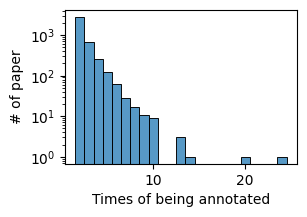

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

paper_id_counts = multi_annotated['paper_id'].value_counts()
plt.figure(figsize=(3, 2))
sns.histplot(x=paper_id_counts, bins=30, stat='count', discrete=True)
plt.yscale('log')
plt.xlabel('Times of being annotated')
plt.ylabel('# of paper')
plt.show()

In [ ]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    scores = evaluate_metrics(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(scores)

  0%|                                                                                                                                      | 0/10 [00:00<?, ?it/s][nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
 10%|████████████▌                                                                                                                 | 1/10 [00:12<01:50, 12.32s/it][nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nl

In [ ]:
# 计算平均分
bleu_avg = sum(s['bleu'] for s in all_scores) / n_sample
meteor_avg = sum(s['meteor'] for s in all_scores) / n_sample
rouge_avg = {}
for rouge_type in ["rouge1", "rouge2", "rougeL"]:
    rouge_avg[rouge_type] = sum(s['rouge'][rouge_type] for s in all_scores) / n_sample

print("=== 10次抽样平均 ===")
print("BLEU: {:.4f}".format(bleu_avg))
print("METEOR: {:.4f}".format(meteor_avg))
print("ROUGE (F):")
for rouge_type in ["rouge1", "rouge2", "rougeL"]:
    print("  {}: {:.4f}".format(rouge_type.upper(), rouge_avg[rouge_type]))

=== 10次抽样平均 ===
BLEU: 0.0452
METEOR: 0.2159
ROUGE (F):
  ROUGE1: 0.2739
  ROUGE2: 0.0679
  ROUGEL: 0.2166


## Abstracts as references

In [5]:
evaluate_metrics(df, pred_col='gemma3', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.0015324374033827534,
 'rouge': {'rouge1': np.float64(0.178899423182238),
  'rouge2': np.float64(0.0687364958628883),
  'rougeL': np.float64(0.13063263718495793)},
 'meteor': np.float64(0.0955440723649232)}

In [6]:
evaluate_metrics(df, pred_col='llama4', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.0012659313729019544,
 'rouge': {'rouge1': np.float64(0.17266882832370087),
  'rouge2': np.float64(0.05188857170643919),
  'rougeL': np.float64(0.11733435621163343)},
 'meteor': np.float64(0.08687230057524462)}

In [12]:
evaluate_metrics(df, pred_col='qwen3', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.03319207318259169,
 'meteor': np.float64(0.19749892250719794),
 'rouge': {'rouge1': np.float64(0.3397127836850643),
  'rouge2': np.float64(0.1271640602084576),
  'rougeL': np.float64(0.20906792437643631)}}

In [15]:
evaluate_metrics(df, pred_col='annotation', ref_col='abstract')

[nltk_data] Downloading package wordnet to /home/zqlyu2/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/zqlyu2/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zqlyu2/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


{'bleu': 0.00014032267591655747,
 'meteor': np.float64(0.06377415902193286),
 'rouge': {'rouge1': np.float64(0.1408848000436993),
  'rouge2': np.float64(0.03825775412279675),
  'rougeL': np.float64(0.10050406185966701)}}

# Simlarity-based

## BERTScore

In [7]:
from bert_score import score

def evaluate_bertscore(df, pred_col='prediction', ref_col='reference'):
    preds = df[pred_col].tolist()
    refs = df[ref_col].tolist()

    P, R, F1 = score(preds, refs, lang='en', 
                     use_fast_tokenizer=True,
                     batch_size=32,
                     verbose=True)  # 如果是中文，改为 lang='zh'
    print(f"BERTScore F1: {F1.mean().item():.4f}")
    return {
        "BERTScore_P": P.mean().item(),
        "BERTScore_R": R.mean().item(),
        "BERTScore_F1": F1.mean().item()
    }


### Human-wrtten annotations as references

#### LLMs' performance

In [8]:
evaluate_bertscore(df, pred_col='gemma3', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2226 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1114 [00:00<?, ?it/s]

done in 113.08 seconds, 315.00 sentences/sec
BERTScore F1: 0.8798


{'BERTScore_P': 0.8760881423950195,
 'BERTScore_R': 0.8838481307029724,
 'BERTScore_F1': 0.879772961139679}

In [9]:
evaluate_bertscore(df, pred_col='llama4', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2226 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1114 [00:00<?, ?it/s]

done in 116.39 seconds, 306.04 sentences/sec
BERTScore F1: 0.8768


{'BERTScore_P': 0.874789297580719,
 'BERTScore_R': 0.8792647123336792,
 'BERTScore_F1': 0.8768314719200134}

In [17]:
evaluate_bertscore(df, pred_col='qwen3', ref_col='annotation')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1113 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/557 [00:00<?, ?it/s]

done in 564.50 seconds, 63.10 sentences/sec
BERTScore F1: 0.8646


{'BERTScore_P': 0.8417383432388306,
 'BERTScore_R': 0.8892121315002441,
 'BERTScore_F1': 0.8646422624588013}

#### Multi-annotated papers as a human-evaluation baseline

In [30]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    scores = evaluate_bertscore(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(scores)

# 计算平均分
bertscore_avg = sum(s['BERTScore_F1'] for s in all_scores) / n_sample

print("=== 10次抽样平均 ===")
print("BERTScore: {:.4f}".format(bertscore_avg))

  0%|                                                                                    | 0/10 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 10%|███████▌                                                                    | 1/10 [00:38<05:50, 39.00s/it]

done in 37.19 seconds, 168.93 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 20%|███████████████▏                                                            | 2/10 [01:16<05:04, 38.12s/it]

done in 37.41 seconds, 167.90 sentences/sec
BERTScore F1: 0.8812


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 30%|██████████████████████▊                                                     | 3/10 [01:55<04:28, 38.29s/it]

done in 37.74 seconds, 166.45 sentences/sec
BERTScore F1: 0.8812


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 40%|██████████████████████████████▍                                             | 4/10 [02:33<03:50, 38.42s/it]

done in 37.65 seconds, 166.86 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 50%|██████████████████████████████████████                                      | 5/10 [03:12<03:12, 38.51s/it]

done in 37.83 seconds, 166.05 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████▌                              | 6/10 [03:50<02:33, 38.31s/it]

done in 37.71 seconds, 166.58 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████▏                      | 7/10 [04:28<01:55, 38.43s/it]

done in 37.82 seconds, 166.09 sentences/sec
BERTScore F1: 0.8813


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████▊               | 8/10 [05:07<01:16, 38.48s/it]

done in 37.64 seconds, 166.84 sentences/sec
BERTScore F1: 0.8814


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████▍       | 9/10 [05:45<00:38, 38.45s/it]

done in 37.64 seconds, 166.86 sentences/sec
BERTScore F1: 0.8811


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/161 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/99 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [06:24<00:00, 38.49s/it]

done in 37.97 seconds, 165.43 sentences/sec
BERTScore F1: 0.8813
=== 10次抽样平均 ===
BERTScore: 0.8812


### Abstracts as references

In [10]:
evaluate_bertscore(df, pred_col='gemma3', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2028 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1114 [00:00<?, ?it/s]

done in 434.40 seconds, 82.00 sentences/sec
BERTScore F1: 0.8607


{'BERTScore_P': 0.8978897333145142,
 'BERTScore_R': 0.8267492055892944,
 'BERTScore_F1': 0.860707700252533}

In [11]:
evaluate_bertscore(df, pred_col='llama4', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2028 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1114 [00:00<?, ?it/s]

done in 518.96 seconds, 68.64 sentences/sec
BERTScore F1: 0.8527


{'BERTScore_P': 0.8875752091407776,
 'BERTScore_R': 0.82086181640625,
 'BERTScore_F1': 0.8527042269706726}

In [8]:
evaluate_bertscore(df, pred_col='qwen3', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1014/1014 [06:49<00:00,  2.48it/s]


computing greedy matching.


100%|██████████| 557/557 [00:18<00:00, 30.23it/s]


done in 431.02 seconds, 82.64 sentences/sec
BERTScore F1: 0.8773


{'BERTScore_P': 0.89637291431427,
 'BERTScore_R': 0.859321653842926,
 'BERTScore_F1': 0.877304196357727}

In [5]:
evaluate_bertscore(df, pred_col='annotation', ref_col='abstract')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1014/1014 [05:34<00:00,  3.03it/s]


computing greedy matching.


100%|██████████| 557/557 [00:17<00:00, 31.90it/s]


done in 354.50 seconds, 100.48 sentences/sec
BERTScore F1: 0.8410


{'BERTScore_P': 0.8739364147186279,
 'BERTScore_R': 0.8107424378395081,
 'BERTScore_F1': 0.840957522392273}

## MoverScore

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
sys.path.append(str(home / 'projects/TLDR/evaluation/ref_based'))

from moverscore_v2 import get_idf_dict, word_mover_score 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def evaluate_moverscore(df, pred_col='prediction', ref_col='reference'):
    preds = df[pred_col].tolist()
    refs = df[ref_col].tolist()

    idf_dict_hyp = get_idf_dict(preds)
    idf_dict_ref = get_idf_dict(refs)

    scores = word_mover_score(refs, preds, idf_dict_ref, idf_dict_hyp, stop_words=stopwords.words('english'))
    print(f'MoverScore: {np.mean(scores):.4f}')

    return np.mean(scores)

tokenizer.model_max_length:  512


[nltk_data] Downloading package stopwords to /home/zqlyu2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Human-written annotations as references

#### LLMs' performace

In [13]:
evaluate_moverscore(df, pred_col='gemma3', ref_col='annotation')

Token indices sequence length is longer than the specified maximum sequence length for this model (14975 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (81328 > 512). Running this sequence through the model will result in indexing errors
Calculating WMS:   0%|                                                                                                                    | 0/279 [00:00<?, ?it/s]DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
Token indices sequence length is longer than the specified maximum sequ

MoverScore: 0.5629


np.float64(0.5629107150349321)

In [14]:
evaluate_moverscore(df, pred_col='llama4', ref_col='annotation')

Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [06:52<00:00,  1.48s/it]

MoverScore: 0.5574


np.float64(0.5574020428751254)

In [20]:
evaluate_moverscore(df, pred_col='qwen3', ref_col='annotation')

Token indices sequence length is longer than the specified maximum sequence length for this model (22174 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2481 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (982 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (38381 > 512). Running this sequence through the model will result in indexing errors
Calculating WMS: 100%|█████████████████████████████████████████████████████████| 279/279 [41:28<00:00,  8.92s/it]


0.5512474859691321

In [7]:
evaluate_moverscore(df, pred_col='qwq', ref_col='annotation')

Calculating WMS: 100%|████████████████████████████████████████████████████████| 279/279 [55:58<00:00, 12.04s/it]


0.5462896681747191

#### Multi-annotated abstracts as a human-evaluation baseline

In [10]:
import random
from tqdm import tqdm

all_scores = []
n_sample = 10  # 抽样次数

for _ in tqdm(range(n_sample)):
    grouped = multi_annotated.groupby('paper_id')
    results = []
    for paper_id, group in grouped:
        annotations = group['annotation'].tolist()
        if len(annotations) < 2:
            continue
        ref = random.choice(annotations)
        preds = [a for a in annotations if a != ref]
        for pred in preds:
            results.append({'paper_id': paper_id, 'reference': ref, 'prediction': pred})

    eval_df = pd.DataFrame(results)
    score = evaluate_moverscore(eval_df, pred_col='prediction', ref_col='reference')
    all_scores.append(score)

# 计算平均分
moverscore_avg = np.mean(all_scores)

print("=== 10次抽样平均 ===")
print("MoverScore: {:.4f}".format(moverscore_avg))

100%|███████████████████████████████████████████████████████████████████████████| 10/10 [07:18<00:00, 43.86s/it]

=== 10次抽样平均 ===
MoverScore: 0.5644


### Abstracts as references

In [15]:
evaluate_moverscore(df, pred_col='gemma3', ref_col='abstract')

Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [30:16<00:00,  6.51s/it]

MoverScore: 0.5489


np.float64(0.5489216601395974)

In [16]:
evaluate_moverscore(df, pred_col='llama4', ref_col='abstract')

Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [38:09<00:00,  8.20s/it]

MoverScore: 0.5404


np.float64(0.5404280791106816)

In [11]:
evaluate_moverscore(df, pred_col='qwen3', ref_col='abstract')

Calculating WMS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [54:37<00:00, 11.75s/it]

MoverScore: 0.5835


np.float64(0.5834857282245158)

In [5]:
evaluate_moverscore(df, pred_col='annotation', ref_col='abstract')

Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (612 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (876 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (747 > 512). Running this sequence through the model will result in indexing errors
Calculating WMS:   0%|          | 0/279 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
DistilBertSdpaAttention is used bu

np.float64(0.5301549328571855)